In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from fbprophet import Prophet

In [2]:
df = pd.read_csv('../data/customer_items.csv', parse_dates=[4],low_memory=False)


In [3]:
from datetime import timedelta
df = df[df['exchange_void_or_return']==0]
df['weekday'] = df['order_date'].dt.weekday
df['week'] = df['order_date'].dt.week
df['week_start'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)-timedelta(days=1)
df['date']= pd.to_datetime(df['order_date'].dt.date)
df=df[df['weekday']!=6]

In [105]:
xf = df
xf = df[df['barcode']==100000004425] # Filter by product

In [106]:
#daily = df.groupby(['date','product_name']).count()['product_quantity'].reset_index()
daily = xf.groupby(['week_start']).count()['product_quantity'].reset_index()

In [107]:
#Usar esto en caso que predecir por venta en vez de número de productos vendidos
#daily = xf.groupby(['week_start']).sum()['order_total'].reset_index()

In [108]:
train_df = daily[daily['week_start'] <= datetime.date(2019,2,3)]
test_df = daily[daily['week_start'] >= datetime.date(2019,2,3)]

/usr/local/dsc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.
/usr/local/dsc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [109]:
#dsY = daily[daily['product_name']=='Agua de Hibisco']
dsY = train_df
renamed = dsY.rename(index=str,columns={'week_start':'ds', 'product_quantity': 'y'})

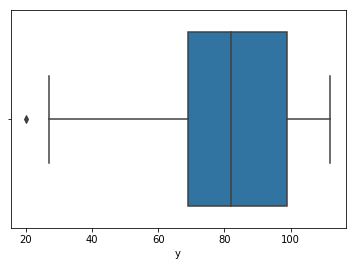

In [110]:
import seaborn as sns
sns.boxplot(x=renamed['y'])

In [111]:
from scipy import stats
import numpy as np

In [112]:
Q1 = renamed.quantile(0.25)
Q3 = renamed.quantile(0.75)
IQR = Q3 - Q1

outlierUp = Q3 + 1.5 * IQR
outlierDown = Q1 - 1.5 * IQR

print(outlierUp, outlierDown)

y    144.0
dtype: float64 y    24.0
dtype: float64


In [113]:
# Quitar outliers
renamed = renamed[(renamed['y'] < outlierUp.y) & (renamed['y'] > outlierDown.y)]

In [114]:
m = Prophet(yearly_seasonality=True,weekly_seasonality=False,daily_seasonality=False)
m.fit(renamed)

/usr/local/dsc/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.0.
/usr/local/dsc/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [115]:
future = m.make_future_dataframe(periods=12,freq = 'w')
#future.tail()

In [116]:
forecast = m.predict(future)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

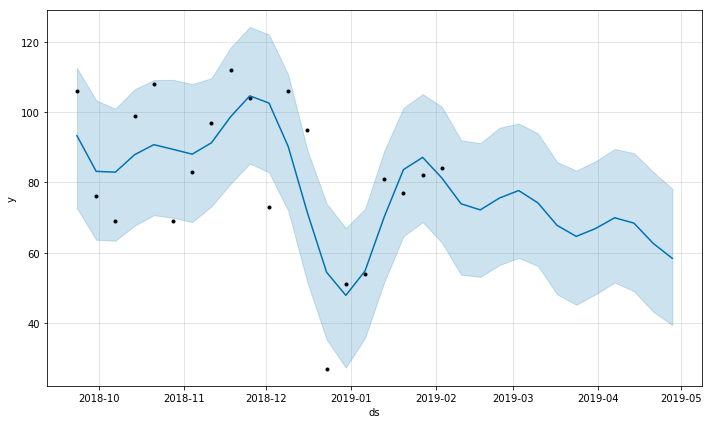

In [117]:
fig1 = m.plot(forecast)

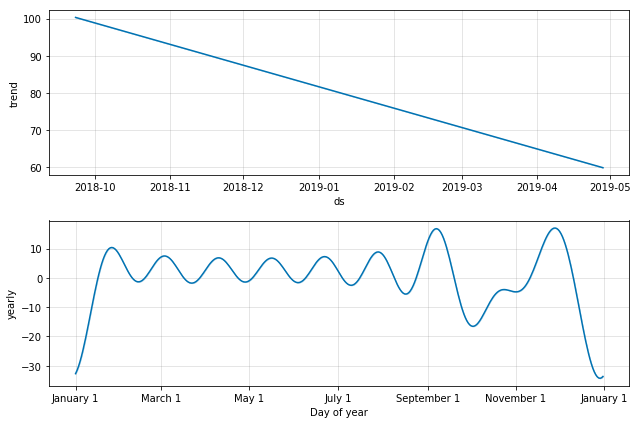

In [118]:
fig2 = m.plot_components(forecast)

21.46613201800158 -21.613683098501237


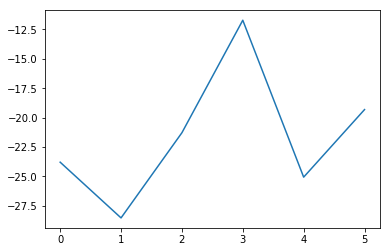

In [119]:
from functools import reduce

def errorEstimation(forecast, test):
    validate = pd.merge(forecast,test,how='inner',left_on='ds',right_on='week_start')

    validate['dif'] = validate['yhat'] - validate['product_quantity']
    validate['difp'] = (validate['dif']*100) / validate['product_quantity']
    validate['rms'] = validate['dif'].map(lambda x: x**2)
    
    meanDiff = validate['difp'].mean()
    rms = validate['rms'].sum()/validate['rms'].count()
    
    print(rms**.5, meanDiff)
    
    return validate[['week_start','dif','rms','difp','product_quantity','yhat','yhat_lower','yhat_upper']]
    

errors=errorEstimation(forecast[forecast['ds'] > min(test_df['week_start'])],test_df)

plt.plot(errors['difp'])

In [120]:
errors[['week_start','yhat','product_quantity','difp']]

,week_start,yhat,product_quantity,difp
0,2019-02-10,73.926682,97,-23.786926
1,2019-02-17,72.188931,101,-28.525810
2,2019-02-24,75.569275,96,-21.282005
3,2019-03-03,77.689931,88,-11.715987
4,2019-03-10,74.192584,99,-25.057996
5,2019-03-17,67.776766,84,-19.313374


In [121]:
train_df.tail()

,week_start,product_quantity
16,2019-01-06,54
17,2019-01-13,81
18,2019-01-20,77
19,2019-01-27,82
20,2019-02-03,84


In [122]:
test_df

,week_start,product_quantity
20,2019-02-03,84
21,2019-02-10,97
22,2019-02-17,101
23,2019-02-24,96
24,2019-03-03,88
25,2019-03-10,99
26,2019-03-17,84


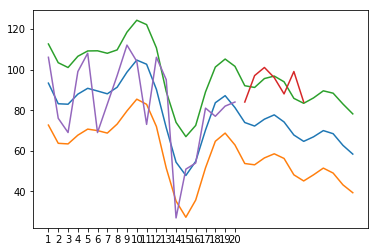

In [123]:
plt.plot(forecast['yhat'])

plt.plot(forecast['yhat_lower'])

plt.plot(forecast['yhat_upper'])

plt.plot(test_df['product_quantity'])
plt.plot(renamed['y'])